In [ ]:
# Imports 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns

from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import torch

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True


c:\Users\earne\Downloads\neural-confidence-journal\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Load base dataset (Week 1–2) and Week 9–10 dataset

base_path = "../week1-2_dataset/confidence_journal_week1-2.csv"
week910_path = "../week9-10_dataset/confidence_journal_week9-10.csv"

df_base = pd.read_csv(base_path)
df_week910 = pd.read_csv(week910_path)

print("Base dataset shape:", df_base.shape)
print("Week 9-10 dataset shape:", df_week910.shape)

print("\nBase head:")
display(df_base.head())

print("\nWeek 9-10 head:")
display(df_week910.head())


Base dataset shape: (50, 2)
Week 9-10 dataset shape: (89, 2)

Base head:


,text,label
0,I kept rewriting the email because I was worri...,0
1,I froze during the stand‑up and stumbled over ...,0
2,I’m second‑guessing the whole plan; maybe I to...,0
3,I felt small in that conversation and didn’t s...,0
4,I looked at the to‑do list and felt like I’ll ...,0



Week 9-10 head:


,text,label
0,I walked into work already second-guessing eve...,0
1,I kept replaying yesterday’s small mistake in ...,0
2,Today I hesitated before speaking in the meeti...,0
3,I stayed quiet when I had an idea because I wa...,0
4,Every time I look at my to-do list I feel over...,0


In [ ]:
# Cleaning and label names

label_map = {0: "Low", 1: "Neutral", 2: "High"}

for df in [df_base, df_week910]:
    df.dropna(subset=["text", "label"], inplace=True)
    df["label"] = df["label"].astype(int)
    df["label_name"] = df["label"].map(label_map)

print("Base dataset after cleaning:", df_base.shape)
print("Week 9-10 dataset after cleaning:", df_week910.shape)


Base dataset after cleaning: (50, 3)
Week 9-10 dataset after cleaning: (89, 3)



Base dataset (Week 1–2) class counts:
label_name
Low        16
Neutral    18
High       16
Name: count, dtype: int64


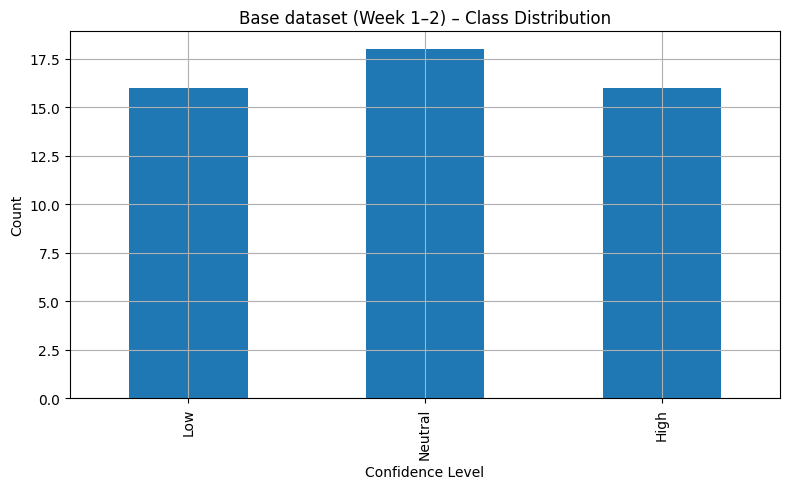


Week 9–10 dataset class counts:
label_name
Low        30
Neutral    29
High       30
Name: count, dtype: int64


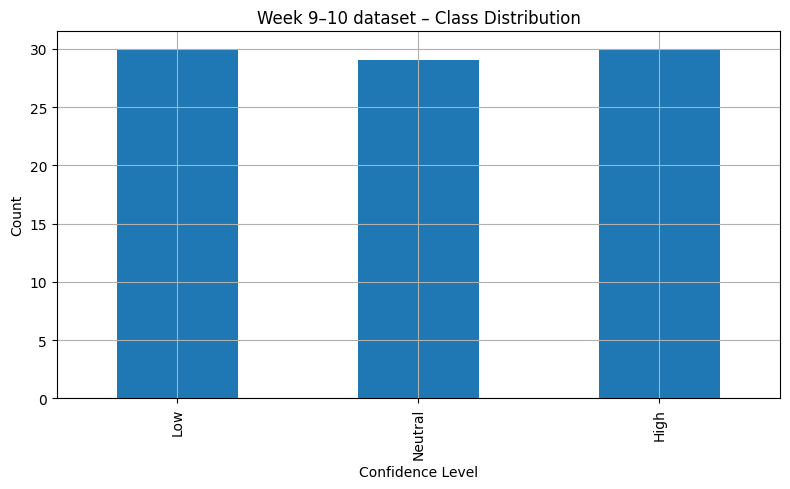


Combined dataset (Week 1–2 + 9–10) class counts:
label_name
Low        46
Neutral    47
High       46
Name: count, dtype: int64


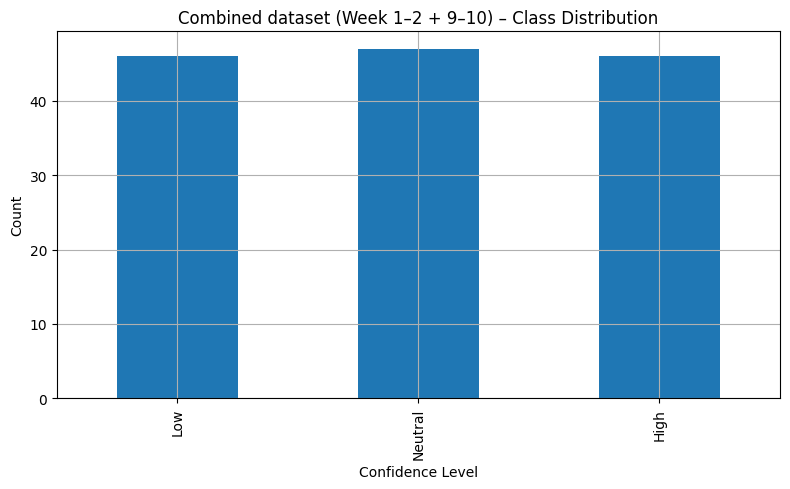

In [ ]:
# Class distribution 

def show_distribution(df, title):
    counts = df["label_name"].value_counts().reindex(["Low", "Neutral", "High"])
    print(f"\n{title} class counts:")
    print(counts)

    counts.plot(kind="bar")
    plt.title(f"{title} – Class Distribution")
    plt.xlabel("Confidence Level")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

show_distribution(df_base, "Base dataset (Week 1–2)")
show_distribution(df_week910, "Week 9–10 dataset")

df_combined = pd.concat([df_base, df_week910], ignore_index=True)
show_distribution(df_combined, "Combined dataset (Week 1–2 + 9–10)")


In [ ]:
# Convert pandas DataFrames to HF Datasets

# random 80/20 split for train/eval
train_df = df_combined.sample(frac=0.8, random_state=42)
eval_df = df_combined.drop(train_df.index)

dataset_dict = {
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "eval": Dataset.from_pandas(eval_df.reset_index(drop=True)),
    "week910": Dataset.from_pandas(df_week910.reset_index(drop=True))
}

datasets_hf = DatasetDict(dataset_dict)
datasets_hf


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name'],
        num_rows: 111
    })
    eval: Dataset({
        features: ['text', 'label', 'label_name'],
        num_rows: 28
    })
    week910: Dataset({
        features: ['text', 'label', 'label_name'],
        num_rows: 89
    })
})

In [ ]:
# Tokenizer and tokenization

# use fine-tuned DistilBERT checkpoint from Week 7–8
MODEL_NAME = "../week7-8_distilbert/week7-8_distilbert/model/checkpoint-18"



tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

tokenized_datasets = datasets_hf.map(tokenize_fn, batched=True)

tokenized_datasets = tokenized_datasets.remove_columns(["text", "label_name"])
tokenized_datasets.set_format(type="torch")
tokenized_datasets


Map: 100%|██████████| 89/89 [00:00<00:00, 5709.24 examples/s]


DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 111
    })
    eval: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 28
    })
    week910: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 89
    })
})

In [ ]:
# Load thefine-tuned DistilBERT model

num_labels = 3

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)


In [ ]:
# Generate predictions on Week 9–10 

def predict_dataset(model, dataset):
    model.eval()
    preds = []
    labels = []
    loader = torch.utils.data.DataLoader(dataset, batch_size=16)

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            batch_preds = torch.argmax(logits, dim=-1).cpu().numpy()
            preds.extend(batch_preds)

            if "label" in batch:
                labels.extend(batch["label"].cpu().numpy())

    return np.array(preds), np.array(labels) if len(labels) > 0 else None

week910_dataset = tokenized_datasets["week910"]
preds_week910, labels_week910 = predict_dataset(model, week910_dataset)

print("Predictions shape:", preds_week910.shape)


Predictions shape: (89,)


Classification Report (Week 9–10):
              precision    recall  f1-score   support

         Low       0.61      0.63      0.62        30
     Neutral       0.52      0.93      0.67        29
        High       0.50      0.10      0.17        30

    accuracy                           0.55        89
   macro avg       0.54      0.55      0.49        89
weighted avg       0.54      0.55      0.48        89



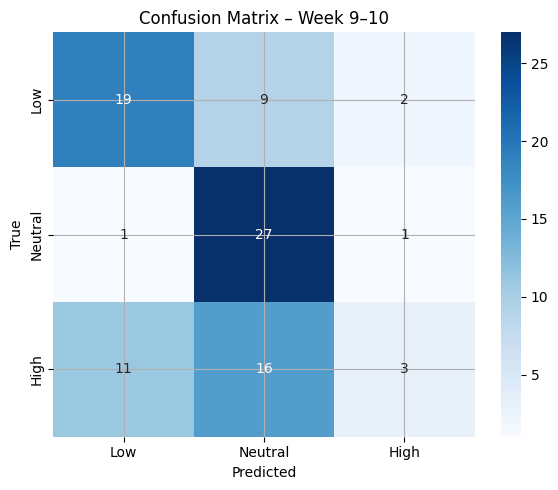

In [ ]:
# Classification report and confusion matrix for Week 9–10 

print("Classification Report (Week 9–10):")
print(classification_report(labels_week910, preds_week910,
                            target_names=["Low", "Neutral", "High"]))

cm = confusion_matrix(labels_week910, preds_week910)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Low", "Neutral", "High"],
            yticklabels=["Low", "Neutral", "High"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Week 9–10")
plt.tight_layout()
plt.savefig("week9-10_confusion_matrix_using_old_model.png", dpi=300, bbox_inches='tight')
plt.show()


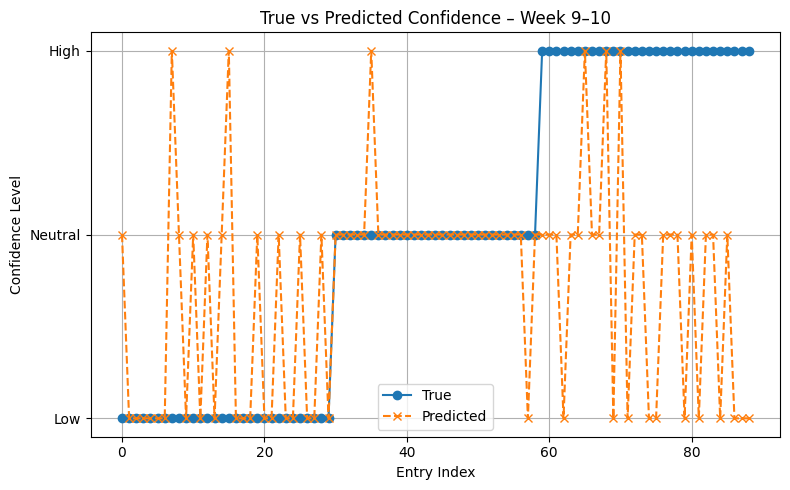

In [ ]:
# True vs Predicted confidence trend over entries 

df_week910_vis = df_week910.copy().reset_index(drop=True)
df_week910_vis["true_label"] = labels_week910
df_week910_vis["pred_label"] = preds_week910
df_week910_vis["entry_index"] = df_week910_vis.index

plt.figure()
plt.plot(df_week910_vis["entry_index"], df_week910_vis["true_label"],
         marker="o", linestyle="-", label="True")
plt.plot(df_week910_vis["entry_index"], df_week910_vis["pred_label"],
         marker="x", linestyle="--", label="Predicted")
plt.yticks([0, 1, 2], ["Low", "Neutral", "High"])
plt.xlabel("Entry Index")
plt.ylabel("Confidence Level")
plt.title("True vs Predicted Confidence – Week 9–10")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# TrainingArguments for retraining on combined dataset 

output_dir = "week9-10_retrained_distilbert"

training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01
)


In [ ]:
# Metrics for Trainer

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "f1": f1_macro}


In [ ]:
# Trainer and training 

train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["eval"]

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


C:\Users\earne\AppData\Local\Temp\ipykernel_20608\236853455.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\earne\Downloads\neural-confidence-journal\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.977893,0.607143,0.586850
2,No log,0.901922,0.750000,0.731207
3,No log,0.811737,0.785714,0.744401
4,No log,0.727435,0.821429,0.794983
5,No log,0.663207,0.821429,0.794983
6,No log,0.629126,0.821429,0.794983
7,No log,0.565252,0.785714,0.761033
8,0.686400,0.539805,0.821429,0.808374
9,0.686400,0.547210,0.821429,0.808374
10,0.686400,0.542063,0.821429,0.808374


c:\Users\earne\Downloads\neural-confidence-journal\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\earne\Downloads\neural-confidence-journal\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\earne\Downloads\neural-confidence-journal\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\earne\Downloads\neural-confidence-journal\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  

TrainOutput(global_step=70, training_loss=0.5744844709123884, metrics={'train_runtime': 482.3965, 'train_samples_per_second': 2.301, 'train_steps_per_second': 0.145, 'total_flos': 36760358684160.0, 'train_loss': 0.5744844709123884, 'epoch': 10.0})

In [ ]:
# Save retrained model and tokenizer 

trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

print("Saved retrained model to:", output_dir)


Saved retrained model to: week9-10_retrained_distilbert


In [ ]:
# Recompute predictions on Week 9–10 with the retrained model
week910_dataset = tokenized_datasets["week910"]
preds_week910, labels_week910 = predict_dataset(model, week910_dataset)

# Rebuild the visual dataframe with new predictions
df_week910_vis = df_week910.copy().reset_index(drop=True)
df_week910_vis["true_label"] = labels_week910
df_week910_vis["pred_label"] = preds_week910
df_week910_vis["entry_index"] = df_week910_vis.index


In [17]:
from sklearn.metrics import classification_report

print("Classification Report (Week 9–10, NEW MODEL):")
print(classification_report(
    labels_week910,
    preds_week910,
    target_names=["Low", "Neutral", "High"]
))


Classification Report (Week 9–10, NEW MODEL):
              precision    recall  f1-score   support

         Low       0.97      0.97      0.97        30
     Neutral       1.00      0.93      0.96        29
        High       0.91      0.97      0.94        30

    accuracy                           0.96        89
   macro avg       0.96      0.95      0.96        89
weighted avg       0.96      0.96      0.96        89



In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load fine-tuned model
model_path = "../week9-10_dataset/week9-10_retrained_distilbert"   
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Prediction function
label_map = {0: "Low", 1: "Neutral", 2: "High"}

def predict_confidence(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()
    return label_map[predicted_class]

# Try a sample journal entry
sample = "I felt unsure about everything today. I kept second-guessing myself, and even small tasks felt harder than they should."
print("Journal Entry:", sample)
print("Predicted Confidence Level:", predict_confidence(sample),"\n")

sample = "Today was pretty average. I got some things done and fell behind on a few others, but overall it felt like a normal day."
print("Journal Entry:", sample)
print("Predicted Confidence Level:", predict_confidence(sample), "\n")

sample = "I was really proud of how I handled things today. I stayed focused, made clear decisions, and felt confident in my work."
print("Journal Entry:", sample)
print("Predicted Confidence Level:", predict_confidence(sample), "\n")



Journal Entry: I felt unsure about everything today. I kept second-guessing myself, and even small tasks felt harder than they should.
Predicted Confidence Level: Low 

Journal Entry: Today was pretty average. I got some things done and fell behind on a few others, but overall it felt like a normal day.
Predicted Confidence Level: Neutral 

Journal Entry: I was really proud of how I handled things today. I stayed focused, made clear decisions, and felt confident in my work.
Predicted Confidence Level: High 



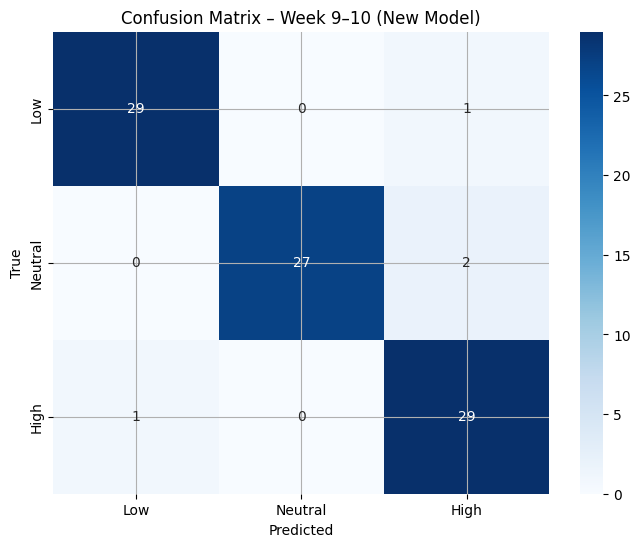

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Build confusion matrix
cm = confusion_matrix(labels_week910, preds_week910)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Low", "Neutral", "High"],
            yticklabels=["Low", "Neutral", "High"])

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Week 9–10 (New Model)")
plt.savefig("week9-10_confusion_matrix_using_new_model.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Misclassified entries 

df_mis = df_week910_vis[df_week910_vis["true_label"] != df_week910_vis["pred_label"]].copy()
df_mis["true_name"] = df_mis["true_label"].map(label_map)
df_mis["pred_name"] = df_mis["pred_label"].map(label_map)

print("Number of misclassified entries:", len(df_mis))
df_mis[["entry_index", "text", "true_name", "pred_name"]].head(10)


Number of misclassified entries: 4


,entry_index,text,true_name,pred_name
25,25,I caught myself editing my personality around ...,Low,High
49,49,I felt okay with asking a couple of clarifying...,Neutral,High
57,57,"When the day ended, I didn’t feel particularly...",Neutral,High
88,88,I went to bed tonight with the sense that I’m ...,High,Low
